In [1]:
#!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install tensorflow
!pip3 install 'gast==0.3.3'
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from scipy.interpolate import splrep, splev

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')
Folder = '/content/drive/My Drive/Colab Notebooks/2021_OEN/'

Mounted at /content/drive


In [4]:
f_model = keras.models.load_model(Folder + "8L_model_20")
X = pd.read_csv(Folder + 'saveT_20.csv')
y = pd.read_csv(Folder + 'saveL_20.csv')

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, X, test_size=0.25)

input_shape = [X_train.shape[1]]

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)

Model Compile Runtime :  1907.0
Minimum Train Loss : 0.0588 
 Minimum Validation Loss: 0.0581


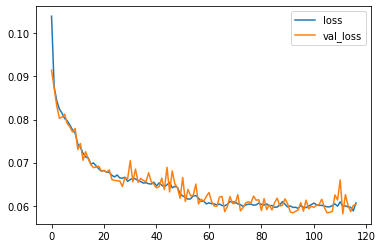

In [9]:
b_model = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=input_shape),
    layers.Dense(500, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(8, activation='relu')
])

model = keras.Sequential([
    b_model,
    f_model
])

f_model.trainable = False

model.compile(
    optimizer='adam',
    loss='mae',
)

compile_start = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=100,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,
)
compile_end = time.time()
print("Model Compile Runtime : ", np.round(compile_end - compile_start))

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Train Loss : {:0.4f} \n Minimum Validation Loss: {:0.4f}".format(history_df['loss'].min(), history_df['val_loss'].min()))

In [10]:
b_model.save(Folder + "8L_transfer_model_20_Theme_sqloss", save_format='tf')
load_model = keras.models.load_model(Folder + "8L_transfer_model_20_Theme_sqloss")
load_model.summary()

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/2021_OEN/8L_transfer_model_20_Theme_sqloss/assets
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               40400     
_________________________________________________________________
dense_10 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_12 (Dense)             (None, 20)                4020      
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 168       
Total params: 245,288
Trainable params: 245,288
Non-trainable params: 0
_______________________________________________________

In [11]:
X_RT = pd.read_csv(Folder + 'RTtest_T.csv')
cal_RT = pd.read_csv(Folder + 'RTtest_L.csv')
cal_RT_output = (cal_RT - 40) / 160

predict_start = time.time()
predict_RT_output =  load_model.predict(X_RT)
predict_end = time.time()
predict_RT = np.round(predict_RT_output * 160 + 40)
print("Prediction Runtime : ", np.round(predict_end - predict_start, 2))

Prediction Runtime :  1.97


In [14]:
X_RT = pd.read_csv(Folder + 'sigma.csv')
predict_RT_output =  load_model.predict(X_RT)
predict_RT = np.round(predict_RT_output * 160 + 40)

In [15]:
# Material Data
Dict_M = ['Air','Ag','Alq3','C60','CuPC','SiO2','SiNx']
OriginData = np.zeros(7, dtype=object)
OriginData[1] = pd.read_csv(Folder + 'Ag.dat', skipinitialspace=True)  # Ag
OriginData[2] = pd.read_csv(Folder + 'Alq3.dat', skipinitialspace=True)  # Alq3
OriginData[3] = pd.read_csv(Folder + 'c60.dat', skipinitialspace=True)  # c60
OriginData[4] = pd.read_csv(Folder + 'cupc.dat', skipinitialspace=True)  # cupc
OriginData[5] = 1.50  # sio2
OriginData[6] = 1.91  # sinx

Points = 200+1
Lambda = np.linspace(400, 800, Points)  # case 1
j = complex(0, 1)

Index = np.zeros((7, 2, Points))
Index[0][0] = np.full(Points, 1.00)
Index[0][1] = np.zeros(Points)
for i in range(1, 5):
    Index[i][0] = np.array(splev(Lambda, splrep(OriginData[i]['lambda'], OriginData[i]['n'])))
    Index[i][1] = np.array(splev(Lambda, splrep(OriginData[i]['lambda'], OriginData[i]['k'])))
Index[5][0] = np.full(Points, 1.50)
Index[5][1] = np.zeros(Points)
Index[6][0] = np.full(Points, 1.91)
Index[6][1] = np.zeros(Points)

Ksquare = np.zeros((7, Points), dtype=complex)
for i in range(7):
    Ksquare[i] = np.ravel(np.square(np.divide(np.ravel(np.transpose(Index[i]) @ np.array([[1], [j]])), Lambda) * 2*np.pi/(10**-9)))

# Layer conditions
Set_M = np.array([5, 6])  # 0~6 : vacuum, ag, alq3, c60, cupc, sio2, sinx
set_num = len(Set_M)
REP = 4
Data_num = X_RT.shape[0]

def Lm(q, q_next, d):
    Q = np.array([np.array([[(q + q_next) / q_next / 2, (q_next - q) / q_next / 2], [(q_next - q) / q_next / 2, (q + q_next) / q_next / 2]]).swapaxes(0,2), ]*Data_num)
    D = np.multiply(np.eye(2), np.array([np.exp(j * np.outer(q, d).ravel()), np.exp(-j * np.outer(q, d).ravel())]).swapaxes(0, 1)[:, np.newaxis]).reshape(Data_num, Points, 2, 2)
    return Q @ D
vLm = np.vectorize(Lm, otypes=[np.ndarray])

def cal_input(Set_T = np.array(predict_RT)):
    M = np.array([np.identity(2), ]*Data_num*Points).reshape(Data_num, Points, 2, 2)
    q = np.sqrt(np.array(Ksquare[0]))
    q_next = np.sqrt(np.array(Ksquare[Set_M[0]]))
    M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel([0,]*Data_num)), M)
    q = q_next
    for i in range(1, set_num*REP):
        q_next = np.sqrt(np.array(Ksquare[Set_M[i % set_num]]))
        M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel(Set_T.transpose()[i-1]*(10**-9))), M)
        q = q_next
    q_next = np.sqrt(np.array(Ksquare[0]))
    M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel(Set_T.transpose()[set_num*REP-1]*(10**-9))), M)
    M = np.reshape(M, (Data_num*Points, 4)).transpose()
    r, t = -M[2]/M[3], M[0]-M[1]*M[2]/M[3]
    R, T = np.reshape(abs(r)**2, (Points, Data_num)).transpose(), np.reshape(abs(t)**2, (Points, Data_num)).transpose()
    T = np.round(T, 4)
    return T

predict_RT_cal = cal_input()

T Loss :  0.0643


Predicted Layer thickness :  [ 57. 187. 148. 120.  48. 105.  40.  68.]
T Loss of Example:  0.0478


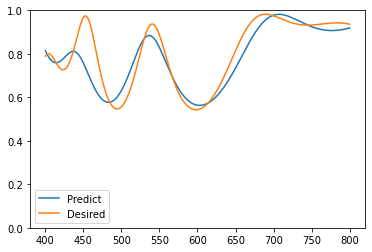

In [13]:
idx = 1
predict_ex = predict_RT_cal[idx]
cal_ex = np.array(X_RT)[idx]
#print("(Scaled) Test Loss : ", np.round(np.average(np.abs(predict_RT_output - cal_RT_output)), 4))
print("T Loss : ", np.round(np.average(np.abs(predict_RT_cal - X_RT)), 4))
print("\n")
#print("Correct Layer thickness : ", np.array(cal_RT)[idx])
print("Predicted Layer thickness : ", predict_RT[idx])
plt.plot(Lambda, predict_ex.reshape(Points,), label='Predict')
plt.plot(Lambda, cal_ex.reshape(Points,), label='Desired')
plt.ylim(0.0, 1.0)
plt.legend()
print("T Loss of Example: ", np.round(np.average(np.abs(predict_ex - cal_ex)), 4))

T Loss :  0.1064
Predicted Layer thickness :  [ 46. 219. 127.  74.  87. 106.  40.  94.]
T Loss of Example:  0.1234
T Loss :  0.1064
Predicted Layer thickness :  [ 40. 220.  77. 112.  73.  98.  40. 109.]
T Loss of Example:  0.0844
T Loss :  0.1064
Predicted Layer thickness :  [ 45. 209.  87. 154.  40.  52.  40. 140.]
T Loss of Example:  0.1115


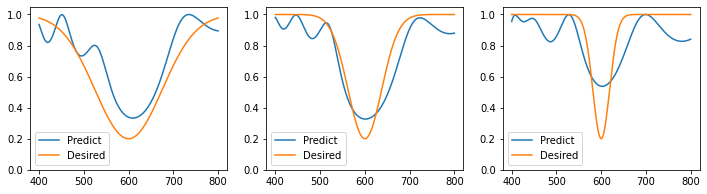

In [16]:
plt.figure(figsize=(12, 3))
for idx in range(3):
  predict_ex = predict_RT_cal[idx]
  cal_ex = np.array(X_RT)[idx]
  plt.subplot(1, 3, idx+1)
  print("T Loss : ", np.round(np.average(np.abs(predict_RT_cal - X_RT)), 4))
  print("Predicted Layer thickness : ", predict_RT[idx])
  plt.plot(Lambda, predict_ex.reshape(Points,), label='Predict')
  plt.plot(Lambda, cal_ex.reshape(Points,), label='Desired')
  plt.ylim(0.0, 1.05)
  plt.legend()
  print("T Loss of Example: ", np.round(np.average(np.abs(predict_ex - cal_ex)), 4))